# Load data

In [1]:
!ls -lht data/

total 40G
-rw-r--r-- 1 mpaganini users 594M Mar 22 23:03 dataset_val_ca2044e.h5
-rw-r--r-- 1 mpaganini users 594M Mar 22 22:33 dataset_train_ca2044e.h5
-rw-r--r-- 1 mpaganini users 595M Mar 22 22:04 dataset_test_ca2044e.h5
-rw-r--r-- 1 mpaganini users 594M Mar 22 17:37 dataset_val_e1152e3.h5
-rw-r--r-- 1 mpaganini users 592M Mar 22 17:12 dataset_train_e1152e3.h5
-rw-r--r-- 1 mpaganini users 594M Mar 22 16:47 dataset_test_e1152e3.h5
-rw-r--r-- 1 mpaganini users 5.8G Mar 14 01:03 dataset_test_c48e913.h5
-rw-r--r-- 1 mpaganini users 5.8G Mar 14 00:45 dataset_val_c48e913.h5
-rw-r--r-- 1 mpaganini users 5.8G Mar 14 00:27 dataset_train_c48e913.h5
-rw-r--r-- 1 mpaganini users 5.8G Mar 14 00:08 dataset_test_894c1bb.h5
-rw-r--r-- 1 mpaganini users 5.9G Mar 13 23:28 dataset_val_894c1bb.h5
-rw-r--r-- 1 mpaganini users 5.8G Mar 13 22:48 dataset_train_894c1bb.h5
drwxr-xr-x 2 mpaganini users 4.0K Mar 13 21:40 old
-rw-r--r-- 1 mpaganini users 595M Mar 13 21:33 dataset_test_0d64b32.h5
-rw-r--r-- 1 mpa

In [2]:
import h5py
import numpy as np

/home/mpaganini/venv/mctuning/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def load_data(filepath):
    with h5py.File(filepath) as f:
        def convert(x):
            if len(x.shape) > 0:
                return np.array(x[:])
            return x
        d = {key : convert(f[key]) for key in f.keys()}
        d['nevents'] = int(d['nevents'].value)
    return d

In [4]:
# mu = 1.0
d_train_0 = load_data('./data/dataset_train_e1152e3.h5')
d_test_0 = load_data('./data/dataset_test_e1152e3.h5')
d_val_0 = load_data('./data/dataset_val_e1152e3.h5')
# mu = 2.0
d_train_1 = load_data('./data/dataset_train_ca2044e.h5')
d_test_1 = load_data('./data/dataset_test_ca2044e.h5')
d_val_1 = load_data('./data/dataset_val_ca2044e.h5')

In [26]:
def make_wxy(d0, d1):
    X_ntrack = np.concatenate((d0['nparticles'], d1['nparticles']))
    X_lead = np.concatenate((d0['leading_jet'], d1['leading_jet']))
    X_sublead = np.concatenate((d0['subleading_jet'], d1['subleading_jet']))
    y = np.concatenate(
        (np.zeros(d0['leading_jet'].shape[0]), np.ones(d1['leading_jet'].shape[0]))
    )
    w = np.concatenate((d0['weights']['Baseline'], d1['weights']['Baseline']))
    return X_ntrack, X_lead, X_sublead, y, w

In [27]:
X_ntrack_train, X_lead_train, X_sublead_train, y_train, w_train = make_wxy(d_train_0, d_train_1)
X_ntrack_val, X_lead_val, X_sublead_val, y_val, w_val = make_wxy(d_val_0, d_val_1)

In [7]:
from sklearn.utils import shuffle

In [29]:
X_ntrack_train, X_lead_train, X_sublead_train, y_train, w_train = shuffle(
    X_ntrack_train, X_lead_train, X_sublead_train, y_train, w_train)
X_ntrack_val, X_lead_val, X_sublead_val, y_val, w_val = shuffle(
    X_ntrack_val, X_lead_val, X_sublead_val, y_val, w_val)

In [36]:
X_ntrack_train = (X_ntrack_train - 50) / 100.
X_ntrack_val = (X_ntrack_val - 50) / 100.

### Dataset stats

In [30]:
print y_train.mean(), y_train.mean()

0.5020145420196731 0.5020145420196731


In [31]:
print X_lead_train.min(), X_lead_train.max(), X_lead_train.mean(), X_lead_train.std()

-6.648112 5.1463146 0.008680125 0.4628737


In [32]:
print X_lead_val.min(), X_lead_val.max(), X_lead_val.mean(), X_lead_val.std()

-5.892642 5.895517 0.009669775 0.4608668


In [33]:
print X_sublead_train.min(), X_sublead_train.max(), X_sublead_train.mean(), X_sublead_train.std()

-6.9167986 6.4235067 0.009163888 0.46920964


In [34]:
print X_sublead_val.min(), X_sublead_val.max(), X_sublead_val.mean(), X_sublead_val.std()

-6.373785 6.0668316 0.008921437 0.47067508


In [37]:
print X_ntrack_train.min(), X_ntrack_train.max(), X_ntrack_train.mean(), X_ntrack_train.std()

-0.49 1.06 -0.059298787 0.18358342


In [38]:
print X_ntrack_val.min(), X_ntrack_val.max(), X_ntrack_val.mean(), X_ntrack_val.std()

-0.49 1.01 -0.058638915 0.18383569


# Design RNN Model

In [155]:
from keras.layers import Input, LSTM, Dropout, Bidirectional, concatenate, Masking, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [110]:
x_lead = Input(X_lead_train.shape[1:])
x_sublead = Input(X_sublead_train.shape[1:])

masked_lead = Masking()(x_lead)
masked_sublead = Masking()(x_sublead)

In [111]:
lstm_lead = Bidirectional(LSTM(32, recurrent_dropout=0.2))(masked_lead)
lstm_sublead = Bidirectional(LSTM(32, recurrent_dropout=0.2))(masked_sublead)
h = concatenate([lstm_lead, lstm_sublead])
h = Dropout(0.6)(h)
h = Dense(128, activation='relu')(h)
h = Dropout(0.6)(h)
out = Dense(1, activation='sigmoid')(h)

In [112]:
model = Model(inputs=[x_lead, x_sublead], outputs=out)

In [113]:
model.compile('RMSprop', 'binary_crossentropy')

In [114]:
model.fit([X_lead_train, X_sublead_train], y_train, sample_weight=w_train.ravel(), verbose=1, batch_size=128,
          validation_data=([X_lead_val, X_sublead_val], y_val, w_val.ravel()),
          callbacks=[
                        ModelCheckpoint('rnn_best.h5', monitor='val_loss', verbose=1, save_best_only=True),
                        EarlyStopping(monitor='val_loss', patience=20, verbose=1)

                    ],
          epochs=20)

Train on 171503 samples, validate on 171727 samples
Epoch 1/20
171503/171503 [==============================] - 169s 988us/step - loss: 0.6959 - val_loss: 0.6932
Epoch 2/20
171503/171503 [==============================] - 166s 969us/step - loss: 0.6934 - val_loss: 0.6933
Epoch 3/20
171503/171503 [==============================] - 167s 975us/step - loss: 0.6930 - val_loss: 0.6928
Epoch 4/20
171503/171503 [==============================] - 166s 970us/step - loss: 0.6923 - val_loss: 0.6924
Epoch 5/20
171503/171503 [==============================] - 166s 969us/step - loss: 0.6918 - val_loss: 0.6921
Epoch 6/20
171503/171503 [==============================] - 166s 970us/step - loss: 0.6914 - val_loss: 0.6919
Epoch 7/20
171503/171503 [==============================] - 166s 969us/step - loss: 0.6910 - val_loss: 0.6921
Epoch 8/20
171503/171503 [==============================] - 166s 969us/step - loss: 0.6904 - val_loss: 0.6918
Epoch 9/20
171503/171503 [==============================] - 166s 968

In [42]:
yhat_val = model.predict([X_lead_val, X_sublead_val], verbose=1, batch_size=1024)

171727/171727 [==============================] - 14s 84us/step


In [43]:
yhat_train = model.predict([X_lead_train, X_sublead_train], verbose=1, batch_size=1024)

171503/171503 [==============================] - 14s 82us/step


In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([3.9600e+02, 2.8600e+02, 2.8600e+02, 3.1900e+02, 5.2800e+02,
        5.7200e+02, 5.5000e+02, 6.4900e+02, 8.8000e+02, 1.0450e+03,
        1.5510e+03, 2.0790e+03, 3.3000e+03, 7.6120e+03, 2.9293e+04,
        2.0328e+04, 8.3600e+03, 3.9050e+03, 1.9360e+03, 9.7900e+02,
        4.6200e+02, 3.6300e+02, 1.5400e+02, 9.9000e+01, 1.2100e+02,
        2.2000e+01, 2.2000e+01, 2.2000e+01, 0.0000e+00]),
 array([0.        , 0.03448276, 0.06896552, 0.10344828, 0.13793103,
        0.17241379, 0.20689655, 0.24137931, 0.27586207, 0.31034483,
        0.34482759, 0.37931034, 0.4137931 , 0.44827586, 0.48275862,
        0.51724138, 0.55172414, 0.5862069 , 0.62068966, 0.65517241,
        0.68965517, 0.72413793, 0.75862069, 0.79310345, 0.82758621,
        0.86206897, 0.89655172, 0.93103448, 0.96551724, 1.        ]),
 <a list of 1 Patch objects>)

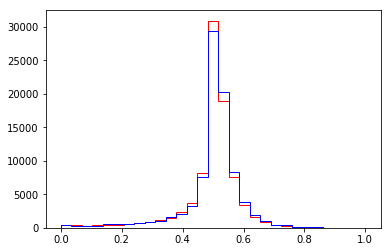

In [48]:
bins = np.linspace(0, 1, 30)
plt.hist(yhat_val[y_val == 0], color='red', bins=bins, histtype='step')
plt.hist(yhat_val[y_val == 1], color='blue', bins=bins, histtype='step')

(array([1.1000e+01, 1.1000e+01, 1.1000e+01, 4.4000e+01, 2.2000e+01,
        8.8000e+01, 6.6000e+01, 8.8000e+01, 1.3200e+02, 2.5300e+02,
        5.5000e+02, 1.0010e+03, 2.2330e+03, 5.5440e+03, 2.8996e+04,
        2.2913e+04, 1.0043e+04, 5.4890e+03, 3.2120e+03, 1.9580e+03,
        1.3750e+03, 7.3700e+02, 4.7300e+02, 3.4100e+02, 2.5300e+02,
        1.3200e+02, 1.2100e+02, 0.0000e+00, 0.0000e+00]),
 array([0.        , 0.03448276, 0.06896552, 0.10344828, 0.13793103,
        0.17241379, 0.20689655, 0.24137931, 0.27586207, 0.31034483,
        0.34482759, 0.37931034, 0.4137931 , 0.44827586, 0.48275862,
        0.51724138, 0.55172414, 0.5862069 , 0.62068966, 0.65517241,
        0.68965517, 0.72413793, 0.75862069, 0.79310345, 0.82758621,
        0.86206897, 0.89655172, 0.93103448, 0.96551724, 1.        ]),
 <a list of 1 Patch objects>)

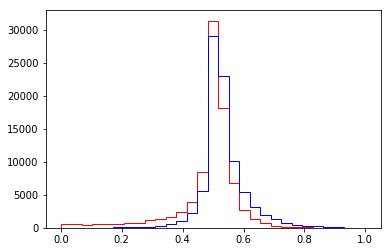

In [49]:
bins = np.linspace(0, 1, 30)
plt.hist(yhat_train[y_train == 0], color='red', bins=bins, histtype='step')
plt.hist(yhat_train[y_train == 1], color='blue', bins=bins, histtype='step')

# Design n_track Model

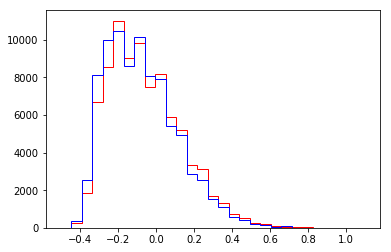

In [59]:
bins = np.linspace(-0.5, 1.1, 30)
_ = plt.hist(X_ntrack_train[y_train == 0, 0], color='red', bins=bins, histtype='step')
_ = plt.hist(X_ntrack_train[y_train == 1, 0], color='blue', bins=bins, histtype='step')

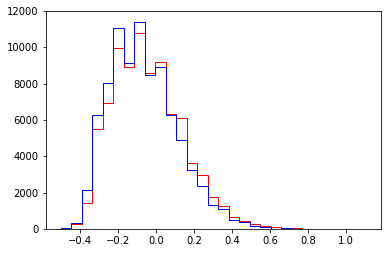

In [58]:
bins = np.linspace(-0.5, 1.1, 30)
_ = plt.hist(X_ntrack_train[y_train == 0, 1], color='red', bins=bins, histtype='step')
_ = plt.hist(X_ntrack_train[y_train == 1, 1], color='blue', bins=bins, histtype='step')

(array([2.2000e+01, 1.1000e+01, 6.6000e+01, 7.7000e+01, 9.9000e+01,
        1.8700e+02, 2.8600e+02, 5.8300e+02, 6.8200e+02, 1.2760e+03,
        2.0350e+03, 3.3330e+03, 6.5340e+03, 1.1000e+04, 2.3826e+04,
        1.3310e+04, 8.4480e+03, 5.3570e+03, 3.5640e+03, 2.3980e+03,
        1.3310e+03, 9.1300e+02, 4.0700e+02, 1.6500e+02, 5.5000e+01,
        6.6000e+01, 2.2000e+01, 1.1000e+01, 1.1000e+01]),
 array([-0.2       , -0.1862069 , -0.17241379, -0.15862069, -0.14482759,
        -0.13103448, -0.11724138, -0.10344828, -0.08965517, -0.07586207,
        -0.06206897, -0.04827586, -0.03448276, -0.02068966, -0.00689655,
         0.00689655,  0.02068966,  0.03448276,  0.04827586,  0.06206897,
         0.07586207,  0.08965517,  0.10344828,  0.11724138,  0.13103448,
         0.14482759,  0.15862069,  0.17241379,  0.1862069 ,  0.2       ]),
 <a list of 1 Patch objects>)

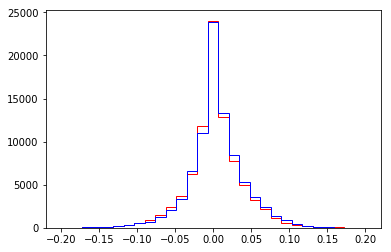

In [63]:
bins = np.linspace(-0.2, 0.2, 30)
plt.hist(X_ntrack_train[y_train == 0, 0] * X_ntrack_train[y_train == 0, 1], color='red', bins=bins, histtype='step')
plt.hist(X_ntrack_train[y_train == 1, 0] * X_ntrack_train[y_train == 1, 1], color='blue', bins=bins, histtype='step')

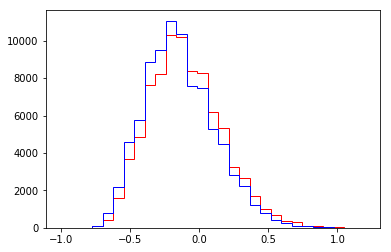

In [66]:
bins = np.linspace(-1.0, 1.2, 30)
_ = plt.hist(X_ntrack_train[y_train == 0, 0] + X_ntrack_train[y_train == 0, 1], color='red', bins=bins, histtype='step')
_ = plt.hist(X_ntrack_train[y_train == 1, 0] + X_ntrack_train[y_train == 1, 1], color='blue', bins=bins, histtype='step')

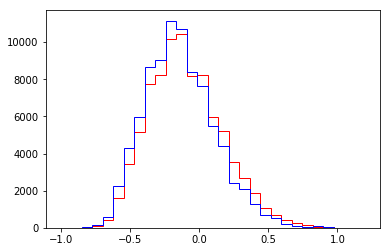

In [67]:
bins = np.linspace(-1.0, 1.2, 30)
_ = plt.hist(X_ntrack_val[y_val == 0, 0] + X_ntrack_val[y_val == 0, 1], color='red', bins=bins, histtype='step')
_ = plt.hist(X_ntrack_val[y_val == 1, 0] + X_ntrack_val[y_val == 1, 1], color='blue', bins=bins, histtype='step')

In [156]:
x = Input(X_ntrack_train.shape[1:])
h = Dense(20, activation='relu')(x)
h = Dropout(0.2)(h)
h = Dense(20, activation='relu')(h)
h = Dropout(0.2)(h)
h = Dense(128, activation='relu')(h)
h = Dropout(0.2)(h)
h = Dense(128, activation='relu')(h)
h = Dropout(0.2)(h)
h = Dense(20, activation='relu')(h)
h = Dropout(0.2)(h)
out = Dense(1, activation='sigmoid')(h)

In [157]:
ntrack_model = Model(x, out)

In [159]:
ntrack_model.compile('RMSProp', 'binary_crossentropy')

In [160]:
ntrack_model.fit(X_ntrack_train, y_train, sample_weight=w_train.ravel(), verbose=1, batch_size=100,
                    validation_data=(X_ntrack_val, y_val, w_val.ravel()),
                    callbacks=[
                        ModelCheckpoint('ntrack_best.h5', monitor='val_loss', verbose=1, save_best_only=True),
                        EarlyStopping(monitor='val_loss', patience=20, verbose=1)

                    ],
                    epochs=200)

Train on 171503 samples, validate on 171727 samples
Epoch 1/200
171503/171503 [==============================] - 11s 63us/step - loss: 0.6910 - val_loss: 0.6904

Epoch 00001: val_loss improved from inf to 0.69044, saving model to ntrack_best.h5
Epoch 2/200
171503/171503 [==============================] - 9s 52us/step - loss: 0.6905 - val_loss: 0.6903

Epoch 00002: val_loss improved from 0.69044 to 0.69034, saving model to ntrack_best.h5
Epoch 3/200
171503/171503 [==============================] - 8s 49us/step - loss: 0.6905 - val_loss: 0.6902

Epoch 00003: val_loss improved from 0.69034 to 0.69018, saving model to ntrack_best.h5
Epoch 4/200
171503/171503 [==============================] - 9s 52us/step - loss: 0.6904 - val_loss: 0.6904

Epoch 00004: val_loss did not improve
Epoch 5/200
171503/171503 [==============================] - 9s 51us/step - loss: 0.6907 - val_loss: 0.6908

Epoch 00005: val_loss did not improve
Epoch 6/200
171503/171503 [==============================] - 8s 49us/

In [161]:
yhat_ntrack_val = ntrack_model.predict(X_ntrack_val, batch_size=1024, verbose=1)

171727/171727 [==============================] - 1s 6us/step


In [162]:
yhat_ntrack_train = ntrack_model.predict(X_ntrack_train, batch_size=1024, verbose=1)

171503/171503 [==============================] - 0s 2us/step


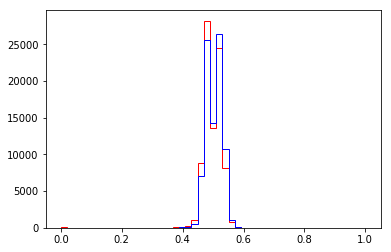

In [163]:
bins = np.linspace(0, 1, 50)
_ = plt.hist(yhat_ntrack_val[y_val == 0], color='red', bins=bins, histtype='step', weights=w_val[y_val == 0])
_ = plt.hist(yhat_ntrack_val[y_val == 1], color='blue', bins=bins, histtype='step', weights=w_val[y_val == 1])

In [200]:
batch_size = 100
batched_0 = []
batched_1 = []
for n in range(sum(y_val == 0)/batch_size):
    batched_0.append(np.prod(yhat_ntrack_val[y_val == 0][n*batch_size: (n+1)*batch_size]))
for n in range(sum(y_val == 1)/batch_size): 
    batched_1.append(np.prod(yhat_ntrack_val[y_val == 1][n*batch_size: (n+1)*batch_size]))

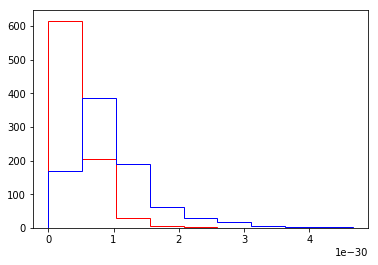

In [201]:
bins = np.linspace(min(min(batched_0), min(batched_1)), max(max(batched_0), max(batched_1)), 10)
_ = plt.hist(batched_0, color='red', histtype='step', bins=bins)
_ = plt.hist(batched_1, color='blue', histtype='step', bins=bins)

In [202]:
from sklearn.metrics import roc_auc_score
roc_auc_score(
    np.concatenate((np.zeros_like(batched_0), np.ones_like(batched_1))),
    np.concatenate((batched_0, batched_1)))

0.8343550207865228